In [1]:
import json
from typing import Collection
from haralyzer import HarPage, HarParser
import os
from numpy import ComplexWarning
import pandas as pd
# from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [119]:
global_list = []
obj_dic = {}
obj_time = []
times = []
final_times = pd.DataFrame(columns = ['PLT', 'HTML_LT', 'CSS_LT', 'JS_LT','Img_LT','Time to First Byte','Id', 'Protocol','Latency','Loss','Bandwidth'])
final_objects = pd.DataFrame(columns = ['Id', 'Mime Type', 'Total Size', 'Num objects', 'Protocol','Latency','Loss','Bandwidth'])

path = os.getcwd() + '/quic_har'
# print(id)
directories = os.listdir(path)
# print(directories)
for directory in directories:
    res = [0,0,0,0,0,0]
    if directory[0] == '.':
        continue
    files = os.listdir('quic_har/' + directory)
    for file in files:
#         print(file, directory)
        with open('quic_har/'+directory+'/'+ file,'r') as f:
            har_parser = HarParser( har_data=json.loads(f.read()))
            file = file[:-4]
            x = directory.split('_')
            protocol = x[0][:-1]
#             print(protocol)
            latency = x[1].split('=')[1]
#             print(latency)
            loss = x[2].split('=')[1]
#             print(loss)
            bandwidth = x[3].split('=')[1]
#             print(bandwidth)

        for page in har_parser.pages:
            res = [page.page_load_time, page.html_load_time, page.css_load_time, page.js_load_time, page.image_load_time, page.time_to_first_byte]
            temp_dict = {}
            for entry in page.entries:
                if entry.response:
                    temp_dict[entry.response.mimeType] = [0,1,protocol,latency,loss,bandwidth]
            for entry in page.entries:
                if entry.response:

                    for dic in entry.response.headers:
                        if dic['name'].lower() == 'content-length':
                            temp_dict[entry.response.mimeType][0]+=int(dic['value'])
                            temp_dict[entry.response.mimeType][1]+=1
                            
            obj_dic[file] = temp_dict
        global_list.append(obj_dic)
        res.append(file)
        times.append(res)
    
    data_all = []
    for obj in global_list:
        for k,v in obj.items():
            for k1,v1 in v.items():
                data_all.append([k]+[k1]+v1)

    df_obj = pd.DataFrame(data_all, columns =['Id', 'Mime Type', 'Total Size', 'Num objects', 'Protocol','Latency','Loss','Bandwidth']) 
    final_objects = pd.concat([final_objects,df_obj])
    
#     print(final_objects)
    
    df_times = pd.DataFrame(times, columns =['PLT', 'HTML_LT', 'CSS_LT', 'JS_LT','Img_LT','Time to First Byte','Id'])
    df_times['Protocol'] = protocol
    df_times['Latency'] = latency
    df_times['Loss'] = loss
    df_times['Bandwidth'] = bandwidth
    final_times = pd.concat([final_times,df_times])

#     print(len(df_obj['Id'].unique()),'Id Unique')
#     print(final_times)

    final_objects['Category'] = 'small'
    final_objects.loc[(final_objects['Total Size'] > 20000) & (final_objects['Total Size'] <= 200000), 'Category'] = 'medium'
    final_objects.loc[(final_objects['Total Size'] > 200000), 'Category'] = 'large'

    df_category = final_objects.groupby(by=['Id','Protocol']).agg({'Total Size':'sum','Num objects':'sum'}).reset_index()
    df_category['Category'] = 'small'
    df_category.loc[(df_category['Total Size'] > 500000) & (df_category['Total Size'] <= 10000000), 'Category'] = 'medium'
    df_category.loc[(df_category['Total Size'] > 10000000), 'Category'] = 'large'

#     print(df_category)
#     print(df_category['Category'].value_counts())

# print(final_times)
# print(final_objects)


In [120]:
duplicate = final_objects[final_objects.duplicated()]
# final_objects.reset_index(inplace = True,drop=True)
# final_objects
duplicate

,Id,Mime Type,Total Size,Num objects,Protocol,Latency,Loss,Bandwidth,Category
70,https-blog-cloudflare-com-http-3-vs-http-2,text/html,0,1,H3,100,0,2,small
71,https-blog-cloudflare-com-http-3-vs-http-2,text/javascript,0,1,H3,100,0,2,small
72,https-blog-cloudflare-com-http-3-vs-http-2,image/gif,84,3,H3,100,0,2,small
73,https-storage-googleapis-com-gweb-uniblog-publ...,image/png,1128358,2,H3,100,0,2,large
74,https-scontent-xx-fbcdn-net-speedtest-100kb,text/plain,102400,2,H3,100,0,2,medium
...,...,...,...,...,...,...,...,...,...
30667,https-www-cloudflare-com-logo,text/javascript,0,1,H3,1,0,10,small
30668,https-www-cloudflare-com-logo,text/plain,0,1,H3,1,0,10,small
30669,https-storage-googleapis-com-gweb-uniblog-publ...,image/jpeg,5048759,2,H3,1,0,10,large
30670,https-scontent-xx-fbcdn-net-speedtest-5mb,text/plain,5242880,2,H3,1,0,10,large


In [121]:

import pandas as pd
import json
from slugify import slugify
# load data using Python JSON module
with open('temp.json','r') as f:
    data = json.load(f)
# Normalizing data
# print(data)
data_nor = []
for k,v in data.items():
    for k1,v1 in v.items():
        temp_dict = dict()
        if k in ['local','brown']:
            continue
        if k1 in ['100KB','1MB','5MB']:
            temp_dict['Id'] = slugify(str(v1))
            temp_dict['size'] = k1
            temp_dict['no_obj'] = 1
            temp_dict['obj_type'] = 'single'
        elif k1 in ['small','medium','large']:
            temp_dict['Id'] = slugify(v1['url'])
            temp_dict['size'] = v1['size']
            temp_dict['no_obj'] = v1['numResources']
            temp_dict['obj_type'] = k1
        temp_dict['origin'] = k
        data_nor.append(temp_dict)
# print(data_nor)
df = pd.DataFrame(data_nor)
print(df)

                                                   Id   size  no_obj obj_type  \
0         https-scontent-xx-fbcdn-net-speedtest-100kb  100KB       1   single   
1           https-scontent-xx-fbcdn-net-speedtest-1mb    1MB       1   single   
2           https-scontent-xx-fbcdn-net-speedtest-5mb    5MB       1   single   
3                   https-about-instagram-com-sitemap   0.43      18    small   
4                              https-www-facebook-com   1.08      59   medium   
5   https-www-facebook-com-business-marketing-part...   1.75      99    large   
6   https-storage-googleapis-com-gweb-uniblog-publ...  100KB       1   single   
7   https-storage-googleapis-com-gweb-uniblog-publ...    1MB       1   single   
8   https-storage-googleapis-com-gweb-uniblog-publ...    5MB       1   single   
9                                https-www-google-com    0.4      27    small   
10                     https-careers-google-com-teams   1.53      37   medium   
11  https-store-google-com-u

In [122]:
final_times = pd.merge(final_times,df,how='left',on='Id')

In [123]:
final_times['HTML_LT'] = pd.to_numeric(final_times['HTML_LT'])
final_times['CSS_LT'] = pd.to_numeric(final_times['CSS_LT'])
final_times['JS_LT'] = pd.to_numeric(final_times['JS_LT']*1.0)
final_times['Img_LT'] = pd.to_numeric(final_times['Img_LT']*1.0)

In [112]:
# final_times.drop(final_times.columns[3],inplace=True, axis=1)
# final_times.drop(final_times.columns[3],inplace=True, axis=1)
# # 

In [124]:
final_times.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 0 to 5399
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PLT                 5400 non-null   float64
 1   HTML_LT             5400 non-null   int64  
 2   CSS_LT              5400 non-null   int64  
 3   JS_LT               5400 non-null   float64
 4   Img_LT              5400 non-null   float64
 5   Time to First Byte  5400 non-null   float64
 6   Id                  5400 non-null   object 
 7   Protocol            5400 non-null   object 
 8   Latency             5400 non-null   object 
 9   Loss                5400 non-null   object 
 10  Bandwidth           5400 non-null   object 
 11  size                5400 non-null   object 
 12  no_obj              5400 non-null   int64  
 13  obj_type            5400 non-null   object 
 14  origin              5400 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 675.0+

In [ ]:
plt_data = final_times.groupby(by=['Protocol','Id','Latency','Loss','Bandwidth','obj_type']).median().reset_index() #agg({'PLT':'median',}).reset_index()
plt_data['PLT'] = plt_data['PLT']/1000
h2_data = plt_data[plt_data['Protocol']=='H2']
h3_data = plt_data[plt_data['Protocol']=='H3']

count, bins_count = np.histogram(h2_data.HTML_LT, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="H2-CDF")
plt.legend()

count, bins_count = np.histogram(h3_data.HTML_LT, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="H3-CDF")
plt.legend()

In [ ]:
# bw_50_loss_0_lat_1_h3 = h3_data[(h3_data['Bandwidth'] == '50') & (h3_data['obj_type'] == 'small') & (h3_data['Loss'] == '2') ]
# bw_50_loss_0_lat_1_h2 = h2_data[(h2_data['Bandwidth'] == '50') & (h2_data['obj_type'] == 'small') & (h2_data['Loss'] == '2') ]
bw_50_loss_0_lat_1_h3 = h3_data[ (h3_data['obj_type'] == 'small') & (h3_data['Loss'] == '2') ]
bw_50_loss_0_lat_1_h2 = h2_data[ (h2_data['obj_type'] == 'small') & (h2_data['Loss'] == '2') ]

# print(h3_data)

count, bins_count = np.histogram(bw_50_loss_0_lat_1_h2.HTML_LT, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="H2-CDF")
plt.legend()

count, bins_count = np.histogram(bw_50_loss_0_lat_1_h3.HTML_LT, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="H3-CDF")
plt.legend()

plt.title("Cumulative PLT, Webpage-Small, Loss-2%, BW-50Mbps")
plt.xlabel("Time(sec)")
plt.ylabel("CDF")
plt.grid()



In [ ]:
bw_50_loss_0_lat_1_h3 = h3_data[ (h3_data['obj_type'] == 'medium') & (h3_data['Loss'] == '2')& (h3_data['Bandwidth'] == '10') & (h3_data['Latency'] == '1')]
bw_50_loss_0_lat_1_h2 = h2_data[ (h2_data['obj_type'] == 'medium') & (h2_data['Loss'] == '2') & (h2_data['Bandwidth'] == '10') & (h2_data['Latency'] == '1')]
# bw_50_loss_0_lat_1_h2 = h3_data[  (h3_data['Loss'] == '2')& (h3_data['Bandwidth'] == '10') & (h3_data['Latency'] == '100')]

# print(h3_data)

count, bins_count = np.histogram(bw_50_loss_0_lat_1_h2.PLT, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="H2-CDF")
plt.legend()

count, bins_count = np.histogram(bw_50_loss_0_lat_1_h3.PLT, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="H3-CDF")
plt.legend()

plt.title("Cumulative PLT, Webpage-Large, Loss-0%, BW-50Mbps")
plt.xlabel("Time(sec)")
plt.ylabel("CDF")
plt.grid()


In [ ]:
# global_list = []
# obj_dic = {}
# obj_time = []
# times = []
# final_times = pd.DataFrame(columns = ['PLT', 'HTML_LT', 'CSS_LT', 'JS_LT','Img_LT','Time to First Byte','Id', 'Protocol','Latency','Loss','Bandwidth'])
# final_objects = pd.DataFrame(columns = ['Id', 'Mime Type', 'Total Size', 'Num objects', 'Protocol','Latency','Loss','Bandwidth'])

path = os.getcwd() + '/quic_har'
# print(id)
directories = os.listdir(path)
obj_times = []
# print(directories)
for directory in directories:
    res = [0,0,0,0,0,0]
    if directory[0] == '.':
        continue
    files = os.listdir('quic_har/' + directory)
    for file in files:
#         print(file, directory)
        with open('quic_har/'+directory+'/'+ file,'r') as f:
            har_parser = HarParser( har_data=json.loads(f.read()))
            file = file[:-4]
            x = directory.split('_')
            protocol = x[0][:-1]
#             print(protocol)
            latency = x[1].split('=')[1]
#             print(latency)
            loss = x[2].split('=')[1]
#             print(loss)
            bandwidth = x[3].split('=')[1]
#             print(bandwidth)

        for page in har_parser.pages:
            res = [page.page_load_time, page.html_load_time, page.css_load_time, page.js_load_time, page.image_load_time, page.time_to_first_byte]
    
            
            for entry in page.entries:
                ob_times_temp = {}
                ob_times_temp['time'] = int(entry.time)/1000
                ob_times_temp ['Protocol' ] = protocol
                ob_times_temp ['Loss' ] = loss
                ob_times_temp ['Bandwidth' ] = bandwidth
                ob_times_temp ['Latency' ] = latency
                ob_times_temp ['obj_size' ] = 1
                ob_times_temp ['PLT'] = page.page_load_time/1000
#                 print(final_times[(final_times['Id']==file) & (final_times['Protocol']==protocol) & (final_times['Loss']==loss) & (final_times['Latency']==latency)]['obj_type'].values[0])

                ob_times_temp ['Category'] = final_times[(final_times['Id']==file) & (final_times['Protocol']==protocol) & (final_times['Loss']==loss) & (final_times['Latency']==latency)]['obj_type'].values[0]
                if ob_times_temp['time'] > 1:
                      continue
#                     print(file, entry.request.url,entry.time,protocol,latency,loss,bandwidth)
                    
                if entry.response:
                    temp_dict[entry.response.mimeType] = [0,1,protocol,latency,loss,bandwidth]
                    ob_times_temp ['mimeType' ] = entry.response.mimeType
                
                for dic in entry.response.headers:
                    if dic['name'].lower() == 'content-length':
                        ob_times_temp ['obj_size' ] = int(dic['value'])
                obj_times.append(ob_times_temp)   


plots = pd.DataFrame(obj_times)

#     print(len(df_obj['Id'].unique()),'Id Unique')
#     print(final_times)

# plots['Category'] = 'small'
# plots.loc[(plots['obj_size'] > 20000) & (plots['obj_size'] <= 200000), 'Category'] = 'medium'
# plots.loc[(plots['obj_size'] > 200000), 'Category'] = 'large'

print(plots)


In [ ]:
plots['Category'].value_counts()

In [ ]:
plots_2 =  final_times[(final_times['Loss'] == '0')]

plots_2.groupby(by=['Protocol','obj_type']).agg({'PLT':'median'}).reset_index(drop=True)
# plots_2['b_cat'] = plots_2['Bandwidth'] + plots_2 ['obj_type']

plots_2 = plots_2[ plots_2['obj_type'].isin(['small','medium','large']) ]

import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
# sns.set(style='white')

#create grouped bar chart
# plt.figure(figsize=(12, 6))
palette ={"H2": "C0", "H3": "C1"}
sns.barplot(x='origin', y='PLT', hue='Protocol', data=plots_2, palette=palette) 



# bw_50_loss_0_lat_1_h3 = plots[ (plots['Protocol'] == 'H3') & (plots['Bandwidth'] == '50') & (plots['Category'] == 'small') & (plots['Loss'] == '2') & (plots['Latency'] == '100')]
# bw_50_loss_0_lat_1_h2 = plots[(plots['Protocol'] == 'H2') &(plots['Bandwidth'] == '50') & (plots['Category'] == 'small') & (plots['Loss'] == '2') & (plots['Latency'] == '100')]

# # print(h3_data)

# count, bins_count = np.histogram(bw_50_loss_0_lat_1_h2.PLT, bins=50000)
# pdf = count / sum(count)
# cdf = np.cumsum(pdf)
# plt.plot(bins_count[1:], cdf, label="H2-CDF")
# plt.legend()

# count, bins_count = np.histogram(bw_50_loss_0_lat_1_h3.PLT, bins=50000)
# pdf = count / sum(count)
# cdf = np.cumsum(pdf)
# plt.plot(bins_count[1:], cdf, label="H3-CDF")

plt.legend()
positions = (0,1, 2, 3,4,5)
labels = ("large(2mbps)", "medium(2mbps)", "small(2mbps)","large(50mbps)", "medium(50mbps)", "small(50mbps)")
# plt.xticks(positions, labels)
plt.title("Time to First Byte (Aggregate)")
plt.ylabel("Time to First Byte (ms)")
plt.xlabel("Webpage")


In [ ]:
plots_2 =  final_times[(final_times['Loss'] == '0')]

plots_2.groupby(by=['Protocol','obj_type']).agg({'PLT':'median'}).reset_index(drop=True)
# plots_2['b_cat'] = plots_2['Bandwidth'] + plots_2 ['obj_type']

plots_2 = plots_2[ plots_2['obj_type'].isin(['small','medium','large']) ]

import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
# sns.set(style='white')

#create grouped bar chart
# plt.figure(figsize=(12, 6))
palette ={"H2": "C0", "H3": "C1"}
sns.barplot(x='obj_type', y='Time to First Byte', hue='Protocol', data=plots_2, palette=palette) 



# bw_50_loss_0_lat_1_h3 = plots[ (plots['Protocol'] == 'H3') & (plots['Bandwidth'] == '50') & (plots['Category'] == 'small') & (plots['Loss'] == '2') & (plots['Latency'] == '100')]
# bw_50_loss_0_lat_1_h2 = plots[(plots['Protocol'] == 'H2') &(plots['Bandwidth'] == '50') & (plots['Category'] == 'small') & (plots['Loss'] == '2') & (plots['Latency'] == '100')]

# # print(h3_data)

# count, bins_count = np.histogram(bw_50_loss_0_lat_1_h2.PLT, bins=50000)
# pdf = count / sum(count)
# cdf = np.cumsum(pdf)
# plt.plot(bins_count[1:], cdf, label="H2-CDF")
# plt.legend()

# count, bins_count = np.histogram(bw_50_loss_0_lat_1_h3.PLT, bins=50000)
# pdf = count / sum(count)
# cdf = np.cumsum(pdf)
# plt.plot(bins_count[1:], cdf, label="H3-CDF")

plt.legend()
positions = (0,1, 2, 3,4,5)
labels = ("large(2mbps)", "medium(2mbps)", "small(2mbps)","large(50mbps)", "medium(50mbps)", "small(50mbps)")
# plt.xticks(positions, labels)
plt.title("Time to First Byte (Aggregate)")
plt.ylabel("Time to First Byte (ms)")
plt.xlabel("Webpage")


In [ ]:
plots_2.groupby(by=['Protocol','obj_type',''])

In [68]:
final_times

,PLT,HTML_LT,CSS_LT,JS_LT,Img_LT,Time to First Byte,Id,Protocol,Latency,Loss,Bandwidth,size,no_obj,obj_type,origin
0,134.238,63,0,75,26,132.119,https-blog-cloudflare-com-http-3-vs-http-2,H3,100,0,2,2.66,87,large,cloudflare
1,257.189,0,0,0,173,59.813,https-storage-googleapis-com-gweb-uniblog-publ...,H3,100,0,2,1MB,1,single,google
2,121.876,0,0,0,0,101.997,https-scontent-xx-fbcdn-net-speedtest-100kb,H3,100,0,2,100KB,1,single,facebook
3,998.579,485,166,1218,872,110.001,https-careers-google-com-teams,H3,100,0,2,1.53,37,medium,google
4,1592.018,638,298,1071,1831,386.878,https-store-google-com-us-category-phones-hl-e...,H3,100,0,2,1.81,98,large,google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,513.026,165,183,690,120,148.312,https-www-facebook-com,H3,1,0,10,1.08,59,medium,facebook
5396,1095.888,509,66,6894,0,246.445,https-www-cloudflare-com-logo,H3,1,0,10,1.09,97,medium,cloudflare
5397,2530.344,0,0,0,2464,190.931,https-storage-googleapis-com-gweb-uniblog-publ...,H3,1,0,10,5MB,1,single,google
5398,2897.901,0,0,0,0,16.130,https-scontent-xx-fbcdn-net-speedtest-5mb,H3,1,0,10,5MB,1,single,facebook


In [170]:
plots_2

,Protocol,HTML_LT,CSS_LT,JS_LT,Img_LT
0,H2,9,0,10.5,119.0
1,H3,9,0,10.5,121.0


TypeError: only size-1 arrays can be converted to Python scalars

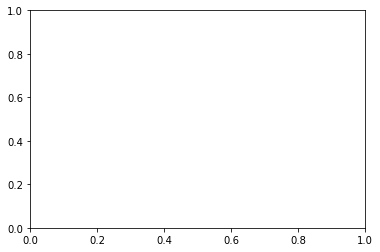

In [191]:
X = ['HTML LT','CSS LT','JS LT','Image LT']
H2 = list(plots_2[plots_2['Protocol']=='H2'][['HTML_LT','CSS_LT','JS_LT','Img_LT']].values.reshape(-1,1))
H3 = list(plots_2[plots_2['Protocol']=='H3'][['HTML_LT','CSS_LT','JS_LT','Img_LT']].values.reshape(-1,1))

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, H3, 0.4, label = 'H2')
plt.bar(X_axis + 0.2, H2, 0.4, label = 'H3')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

In [ ]:
  
# plotting graph
plots_2.plot(x="Protocol", y=["HTML_LT", "CSS_LT","JS_LT", "Img_LT"], kind="bar")

In [85]:
plots_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 0 to 5399
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PLT                 5400 non-null   float64
 1   HTML_LT             5400 non-null   int64  
 2   CSS_LT              5400 non-null   int64  
 3   JS_LT               5400 non-null   object 
 4   Img_LT              5400 non-null   object 
 5   Time to First Byte  5400 non-null   float64
 6   Id                  5400 non-null   object 
 7   Protocol            5400 non-null   object 
 8   Latency             5400 non-null   object 
 9   Loss                5400 non-null   object 
 10  Bandwidth           5400 non-null   object 
 11  size                5400 non-null   object 
 12  no_obj              5400 non-null   int64  
 13  obj_type            5400 non-null   object 
 14  origin              5400 non-null   object 
 15  JS_LT               5400 non-null   int64  
 16  Img_LT

In [172]:
final_times.head()

,PLT,HTML_LT,CSS_LT,JS_LT,Img_LT,Time to First Byte,Id,Protocol,Latency,Loss,Bandwidth,size,no_obj,obj_type,origin
0,134.238,63,0,75.0,26.0,132.119,https-blog-cloudflare-com-http-3-vs-http-2,H3,100,0,2,2.66,87,large,cloudflare
1,257.189,0,0,0.0,173.0,59.813,https-storage-googleapis-com-gweb-uniblog-publ...,H3,100,0,2,1MB,1,single,google
2,121.876,0,0,0.0,0.0,101.997,https-scontent-xx-fbcdn-net-speedtest-100kb,H3,100,0,2,100KB,1,single,facebook
3,998.579,485,166,1218.0,872.0,110.001,https-careers-google-com-teams,H3,100,0,2,1.53,37,medium,google
4,1592.018,638,298,1071.0,1831.0,386.878,https-store-google-com-us-category-phones-hl-e...,H3,100,0,2,1.81,98,large,google


In [187]:
obj_type_l2_bw2 = final_times[(final_times['Bandwidth']=='2') & (final_times['Loss']=='2')]
obj_type_l2_bw50 = final_times[(final_times['Bandwidth']=='50') & (final_times['Loss']=='2')]
print(obj_type_l2_bw2[obj_type_l2_bw2['Bandwidth']=='50'])

Empty DataFrame
Columns: [PLT, HTML_LT, CSS_LT, JS_LT, Img_LT, Time to First Byte, Id, Protocol, Latency, Loss, Bandwidth, size, no_obj, obj_type, origin]
Index: []


In [184]:
obj_type_l2_bw2 = obj_type_l2_bw2.groupby(by=['Protocol']).agg({'HTML_LT':'mean', 'CSS_LT':'mean', 'JS_LT':'mean', "Img_LT":'mean'}).reset_index()
obj_type_l2_bw2

,Protocol,HTML_LT,CSS_LT,JS_LT,Img_LT
0,H2,230.147222,197.262500,653.462500,898.522222
1,H3,238.901961,216.289216,669.408497,945.491830


In [188]:
obj_type_l2_bw50 = obj_type_l2_bw50.groupby(by=['Protocol']).agg({'HTML_LT':'mean', 'CSS_LT':'mean', 'JS_LT':'mean', "Img_LT":'mean'}).reset_index()
obj_type_l2_bw50

,Protocol,HTML_LT,CSS_LT,JS_LT,Img_LT
0,H2,236.108187,204.634503,664.698830,946.394737
1,H3,247.599034,202.845411,686.065217,938.659420


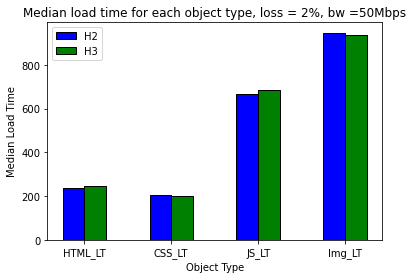

In [189]:
H2 = [236.108187, 204.634503, 664.698830, 946.394737]
H3 = [247.599034, 202.845411, 686.065217, 938.659420]  

n=4
r = np.arange(n)
width = 0.25

plt.bar(r, H2, color = 'b',
        width = width, edgecolor = 'black',
        label='H2')
plt.bar(r + width, H3, color = 'g',
        width = width, edgecolor = 'black',
        label='H3')
  
plt.xlabel("Object Type")
plt.ylabel("Median Load Time")
plt.title("Median load time for each object type, loss = 2%, bw =50Mbps")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,['HTML_LT','CSS_LT','JS_LT','Img_LT'])
plt.legend()
  
plt.show()

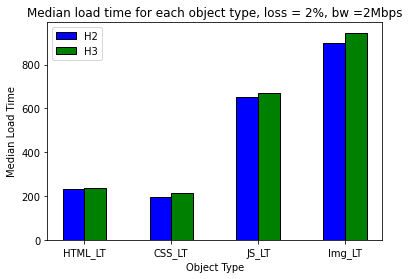

In [190]:
H2 = [230.147222, 197.262500, 653.462500, 898.522222]
H3 = [238.901961, 216.289216, 669.408497, 945.491830]

n=4
r = np.arange(n)
width = 0.25

plt.bar(r, H2, color = 'b',
        width = width, edgecolor = 'black',
        label='H2')
plt.bar(r + width, H3, color = 'g',
        width = width, edgecolor = 'black',
        label='H3')
  
plt.xlabel("Object Type")
plt.ylabel("Median Load Time")
plt.title("Median load time for each object type, loss = 2%, bw =2Mbps")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,['HTML_LT','CSS_LT','JS_LT','Img_LT'])
plt.legend()
  
plt.show()

In [169]:
plots_2 =  final_times.copy()

plots_2 = plots_2.groupby(by=['Protocol']).agg({'HTML_LT':'median', 'CSS_LT':'median', 'JS_LT':'median', "Img_LT":'median'}).reset_index()
# plots_2['b_cat'] = plots_2['Bandwidth'] + plots_2 ['obj_type']

# plots_2 = plots_2[ plots_2['obj_type'].isin(['small','medium','large']) ]

# import matplotlib.pyplot as plt
# import seaborn as sns

# #set seaborn plotting aesthetics
# # sns.set(style='white')

# #create grouped bar chart
# # plt.figure(figsize=(12, 6))
# palette ={"H2": "C0", "H3": "C1"}
# sns.barplot( hue='Protocol', data=plots_2, palette=palette) 
# # sns.barplot(x='obj_type', y='PLT', hue='Protocol', data=plots_2, palette=palette) 



# # bw_50_loss_0_lat_1_h3 = plots[ (plots['Protocol'] == 'H3') & (plots['Bandwidth'] == '50') & (plots['Category'] == 'small') & (plots['Loss'] == '2') & (plots['Latency'] == '100')]
# # bw_50_loss_0_lat_1_h2 = plots[(plots['Protocol'] == 'H2') &(plots['Bandwidth'] == '50') & (plots['Category'] == 'small') & (plots['Loss'] == '2') & (plots['Latency'] == '100')]

# # # print(h3_data)

# # count, bins_count = np.histogram(bw_50_loss_0_lat_1_h2.PLT, bins=50000)
# # pdf = count / sum(count)
# # cdf = np.cumsum(pdf)
# # plt.plot(bins_count[1:], cdf, label="H2-CDF")
# # plt.legend()

# # count, bins_count = np.histogram(bw_50_loss_0_lat_1_h3.PLT, bins=50000)
# # pdf = count / sum(count)
# # cdf = np.cumsum(pdf)
# # plt.plot(bins_count[1:], cdf, label="H3-CDF")

# plt.legend()
# positions = (0,1, 2, 3,4,5)
# labels = ("large(2mbps)", "medium(2mbps)", "small(2mbps)","large(50mbps)", "medium(50mbps)", "small(50mbps)")
# # plt.xticks(positions, labels)
# plt.title("Time to First Byte (Aggregate)")
# plt.ylabel("Time to First Byte (ms)")
# plt.xlabel("Webpage")


In [ ]:
final_objects.groupby(by=['Id','Mime Type','Protocol','Latency','Loss','Bandwidth','Category']).mean()

In [ ]:
final_objects['Total Size'] = final_objects['Total Size'].astype('int')
final_objects['Num objects'] = final_objects['Num objects'].astype('int')

In [ ]:
final_objects[(final_objects['Id'] == 'https-about-instagram-com-sitemap') & (final_objects['Mime Type'] =='application/x-javascript')]